LSH took on average 0.406 seconds per query.
Linear search took on average 0.503 seconds per query.


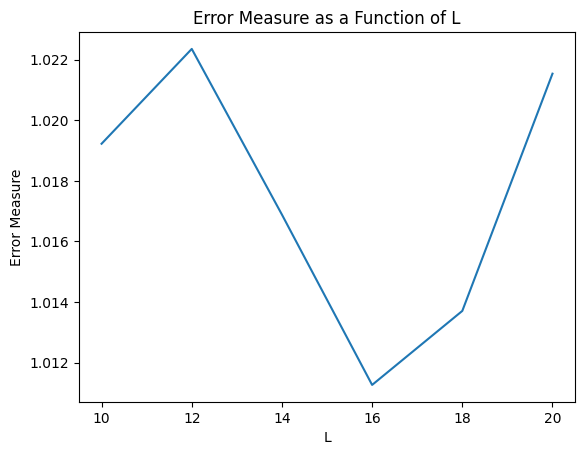

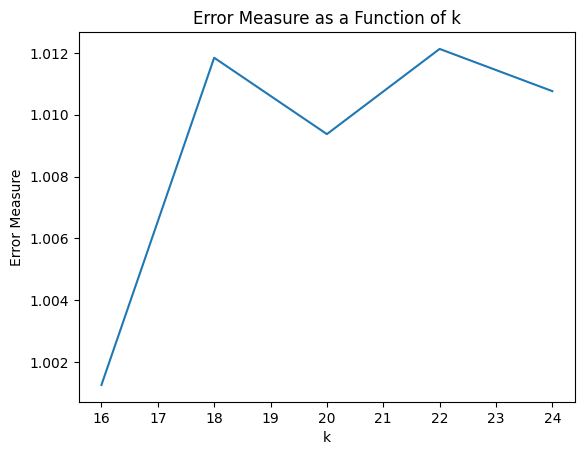

In [8]:
# Authors: Jessica Su, Wanzi Zhou, Pratyaksh Sharma, Dylan Liu, Ansh Shukla
#Modified: Alex Porter
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import pdb
import unittest
from PIL import Image

# Finds the L1 distance between two vectors
# u and v are 1-dimensional np.array objects
# TODO: Implement this
def l1(u, v):
    return np.sum(np.abs(u-v))

# Loads the data into a np array, where each row corresponds to
# an image patch -- this step is sort of slow.
# Each row in the data is an image, and there are 400 columns.
def load_data(filename):
    return np.genfromtxt(filename, delimiter=',')

# Creates a hash function from a list of dimensions and thresholds.
def create_function(dimensions, thresholds):
    def f(v):
        boolarray = [v[dimensions[i]] >= thresholds[i] for i in range(len(dimensions))]
        return "".join(map(str, map(int, boolarray)))
    return f

# Creates the LSH functions (functions that compute L K-bit hash keys).
# Each function selects k dimensions (i.e. column indices of the image matrix)
# at random, and then chooses a random threshold for each dimension, between 0 and
# 255.  For any image, if its value on a given dimension is greater than or equal to
# the randomly chosen threshold, we set that bit to 1.  Each hash function returns
# a length-k bit string of the form "0101010001101001...", and the L hash functions
# will produce L such bit strings for each image.
def create_functions(k, L, num_dimensions=400, min_threshold=0, max_threshold=255):
    functions = []
    for i in range(L):
        dimensions = np.random.randint(low = 0,
                                   high = num_dimensions,
                                   size = k)
        thresholds = np.random.randint(low = min_threshold,
                                   high = max_threshold + 1,
                                   size = k)

        functions.append(create_function(dimensions, thresholds))
    return functions

# Hashes an individual vector (i.e. image).  This produces an array with L
# entries, where each entry is a string of k bits.
def hash_vector(functions, v):
    return np.array([f(v) for f in functions])

# Hashes the data in A, where each row is a datapoint, using the L
# functions in "functions."
def hash_data(functions, A):
    return np.array(list(map(lambda v: hash_vector(functions, v), A)))

# Retrieve all of the points that hash to one of the same buckets
# as the query point.  Do not do any random sampling (unlike what the first
# part of this problem prescribes).
# Don't retrieve a point if it is the same point as the query point.
def get_candidates(hashed_A, hashed_point, query_index):
    return filter(lambda i: i != query_index and \
        any(hashed_point == hashed_A[i]), range(len(hashed_A)))

# Sets up the LSH.  You should try to call this function as few times as
# possible, since it is expensive.
# A: The dataset in which each row is an image patch.
# Return the LSH functions and hashed data structure.
def lsh_setup(A, k = 24, L = 10):
    functions = create_functions(k = k, L = L)
    hashed_A = hash_data(functions, A)
    return (functions, hashed_A)

# Run the entire LSH algorithm
def lsh_search(A, hashed_A, functions, query_index, num_neighbors = 10):
    hashed_point = hash_vector(functions, A[query_index, :])
    candidate_row_nums = get_candidates(hashed_A, hashed_point, query_index)

    distances = map(lambda r: (r, l1(A[r], A[query_index])), candidate_row_nums)
    best_neighbors = sorted(distances, key=lambda t: t[1])[:num_neighbors]

    return [t[0] for t in best_neighbors]

# Plots images at the specified rows and saves them each to files.
def plot(A, row_nums, base_filename):
    for row_num in row_nums:
        patch = np.reshape(A[row_num, :], [20, 20])
        im = Image.fromarray(patch)
        if im.mode != 'RGB':
            im = im.convert('RGB')
        im.save(base_filename + "-" + str(row_num) + ".png")

# Finds the nearest neighbors to a given vector, using linear search.
def linear_search(A, query_index, num_neighbors):
    query_vec = A[query_index, :]
    search_results_list = []
    idx_list = filter(lambda x: x!=query_index, range(len(A)))
    for idx in idx_list:
        search_results_list.append((idx, l1(query_vec, A[idx, :])))
    best_neighbors = sorted(search_results_list, key=lambda x: x[1])[:num_neighbors]
    return [t[0] for t in best_neighbors]

# TODO: Write a function that computes the error measure
def compute_error_measure(A, hashed_A, functions, j_list, num_neighbors=3):
    error_sum = 0
    for j in j_list:
        lsh_top_neighbors = lsh_search(A, hashed_A, functions, j, num_neighbors)
        lin_top_neighbors = linear_search(A, j, num_neighbors)
        error_sum += np.sum([l1(A[j, :], A[top_n, :]) for top_n in lsh_top_neighbors]) / \
                     np.sum([l1(A[j, :], A[top_n, :]) for top_n in lin_top_neighbors])
    return error_sum / len(j_list)


# TODO: Solve Problem 4
def problem4():

    # Load data and setup LSH
    data = load_data('/content/patches.csv')
    h_funcs_og, h_data_og = lsh_setup(data)

    # Average time for top 3 near neighbors
    query_indices = range(100, 1001, 100)

    time_vals = []
    for query_index in query_indices:
        t0 = time.time()
        lsh_search(data, h_data_og, h_funcs_og, query_index, 3)
        t1 = time.time()
        time_vals.append(t1-t0)
    print(f'LSH took on average {np.mean(time_vals):.3f} seconds per query.')

    time_vals = []
    for query_index in query_indices:
        t0 = time.time()
        linear_search(data, query_index, 3)
        t1 = time.time()
        time_vals.append(t1-t0)
    print(f'Linear search took on average {np.mean(time_vals):.3f} seconds per query.')

    # Plot the error value as a function of L:
    l_vals = range(10, 21, 2)
    e_vals = []
    for l_val in l_vals:
        h_funcs, h_data = lsh_setup(data, L=l_val, k=24)
        e_vals.append(compute_error_measure(data, h_data, h_funcs, query_indices, 3))

    fig, ax = plt.subplots()
    ax.plot(l_vals, e_vals)
    ax.set(xlabel='L', ylabel='Error Measure', title='Error Measure as a Function of L')
    fig.savefig("error_vs_L.png")

    # Plot the error value as a function of k:
    k_vals = range(16, 25, 2)
    e_vals = []
    for k_val in k_vals:
        h_funcs, h_data = lsh_setup(data, k=k_val, L=10)
        e_vals.append(compute_error_measure(data, h_data, h_funcs, query_indices, 3))

    fig, ax = plt.subplots()
    ax.plot(k_vals, e_vals)
    ax.set(xlabel='k', ylabel='Error Measure', title='Error Measure as a Function of k')
    fig.savefig("error_vs_k.png")

    # Plot top 10 neighbors found using both methods
    plot(data, [100], 'query_img_')
    plot(data, lsh_search(data, h_data_og, h_funcs_og, 100, 10), 'lsh_')
    plot(data, linear_search(data, 100, 10), 'lin_')

#### TESTS #####

class TestLSH(unittest.TestCase):
    def test_l1(self):
        u = np.array([1, 2, 3, 4])
        v = np.array([2, 3, 2, 3])
        self.assertEqual(l1(u, v), 4)

    def test_hash_data(self):
        f1 = lambda v: sum(v)
        f2 = lambda v: sum([x * x for x in v])
        A = np.array([[1, 2, 3], [4, 5, 6]])
        self.assertEqual(f1(A[0,:]), 6)
        self.assertEqual(f2(A[0,:]), 14)

        functions = [f1, f2]
        self.assertTrue(np.array_equal(hash_vector(functions, A[0, :]), np.array([6, 14])))
        self.assertTrue(np.array_equal(hash_data(functions, A), np.array([[6, 14], [15, 77]])))

    ### TODO: Write your tests here (they won't be graded,
    def test_linear_search(self):
        q_ind = 0
        A = np.array([[0,0,0], [5,0,0], [6,0,0], [7,0,0], [7,5,5], [7,7,7]])
        self.assertEqual(linear_search(A, q_ind, 3), [1,2,3])


if __name__ == '__main__':
#    unittest.main() ### TODO: Uncomment this to run tests
    problem4()